In [1]:
import pandas as pd
from scipy.io import arff

import plotly
plotly.tools.set_credentials_file(username='artemii-yanushevskyi', api_key='aRmQfG7U4SAlhISYVym7')

import plotly.plotly as py
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from IPython.display import Image
import plotly.io as pio

import numpy as np
import seaborn as sns

from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
colormap = plt.cm.RdBu

exporting = True

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import OneHotEncoder

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Abstract

In this article we provide the analysis of the marketing campaign dataset and subsequent classification models. The main goal is to predict, as accurately as possible, whether or not a client will subscribe to a term deposit.

The marketing campaigns were based on phone calls. Each entry in the dataset corresponds to someone who has subscribed to a bank term deposit or not. Often more than one contact to the same client was required, in order to confirm if the product would (or not) be subscribed to.

The raining data consisted of 36169 examples with about 88.4% labelled as a 0 (no subscription) and the rest as 1 (customer subscribed).

Data exploration and visualisation (Pearson correlation, pairplot) showed that the predictability of the classes was poor. 

Attribute selection techniques were applied to the original 17 input variables and two reduced sets, of four and ten attributes were created.

A number of machine learning algorithms were applied to the data and experiments to optimise the meta-parameters were performed.

The best model was a voting committee of four models, which achieved 89.1% (under ten-fold cross-validation).

We also assessed these models (with the same meta-parameter settings) under an unequal cost regime (misclassified bad risks cost five times as much as misclassified good risks). We found that a naive Bayes model trained on the complete dataset performed best, at a cost of 495.

Both models were then applied to an unseen test dataset containing 50 examples. The default rule has an accuracy of 68% and a cost of 34. These models achieved an accuracy of 76% and 31 respectively. The drawbacks of such a small test set are discussed.

# Data Exploration

In [2]:
data, meta = arff.loadarff('cworkTrain.arff')
df = pd.DataFrame(data)

# convert attribute values with type "object" to regular strings
objects_df = df.select_dtypes([object]) # select only atributes of object type
stack_df = objects_df.stack() # means create one column
decoded_stack_df = stack_df.str.decode('utf-8') # decode the values in the column
decoded_objects_df = decoded_stack_df.unstack() # separate into columns

# replace in df
for col in decoded_objects_df.columns:
    df[col] = decoded_objects_df[col]

# replace month with a value
df['month'] = pd.to_datetime(df.month, format='%b').dt.month

display(df.head(), df.shape)
display(df.select_dtypes([object]).describe(), df.select_dtypes([float, int]).describe().round(1))

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,termDeposit
0,58.0,management,married,tertiary,no,2143.0,yes,no,unknown,5.0,5,261.0,1.0,-1.0,0.0,unknown,no
1,44.0,technician,single,secondary,no,29.0,yes,no,unknown,5.0,5,151.0,1.0,-1.0,0.0,unknown,no
2,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5.0,5,76.0,1.0,-1.0,0.0,unknown,no
3,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5.0,5,92.0,1.0,-1.0,0.0,unknown,no
4,35.0,management,married,tertiary,no,231.0,yes,no,unknown,5.0,5,139.0,1.0,-1.0,0.0,unknown,no


(36169, 17)

,job,marital,education,default,housing,loan,contact,poutcome,termDeposit
count,36169,36169,36169,36169,36169,36169,36169,36169,36169
unique,12,3,4,2,2,2,3,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,unknown,no
freq,7808,21746,18594,35512,20049,30363,23416,29621,31981


,age,balance,day,month,duration,campaign,pdays,previous
count,36169.0,36169.0,36169.0,36169.0,36169.0,36169.0,36169.0,36169.0
mean,40.9,1352.8,15.8,6.1,256.7,2.8,39.9,0.6
std,10.6,3028.9,8.3,2.4,255.6,3.1,99.8,2.4
min,18.0,-6847.0,1.0,1.0,0.0,1.0,-1.0,0.0
25%,33.0,70.0,8.0,5.0,103.0,1.0,-1.0,0.0
50%,39.0,445.0,16.0,6.0,180.0,2.0,-1.0,0.0
75%,48.0,1417.0,21.0,8.0,317.0,3.0,-1.0,0.0
max,95.0,98417.0,31.0,12.0,4918.0,63.0,871.0,275.0


In [3]:
df.isnull().any() # if there are any values that are NaN (no)

age            False
job            False
marital        False
education      False
default        False
balance        False
housing        False
loan           False
contact        False
day            False
month          False
duration       False
campaign       False
pdays          False
previous       False
poutcome       False
termDeposit    False
dtype: bool

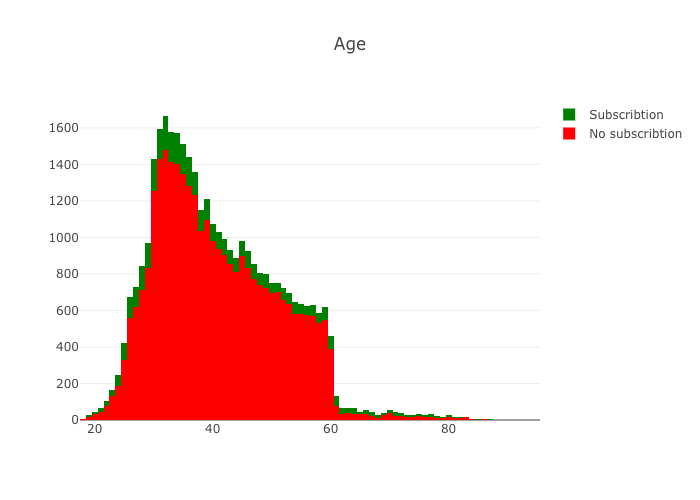

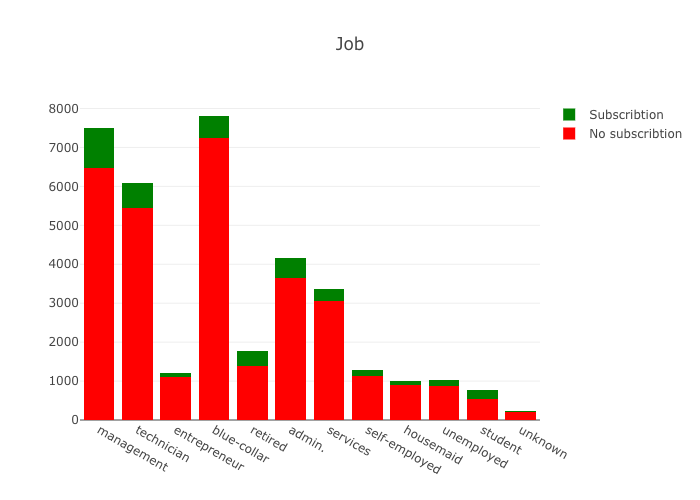

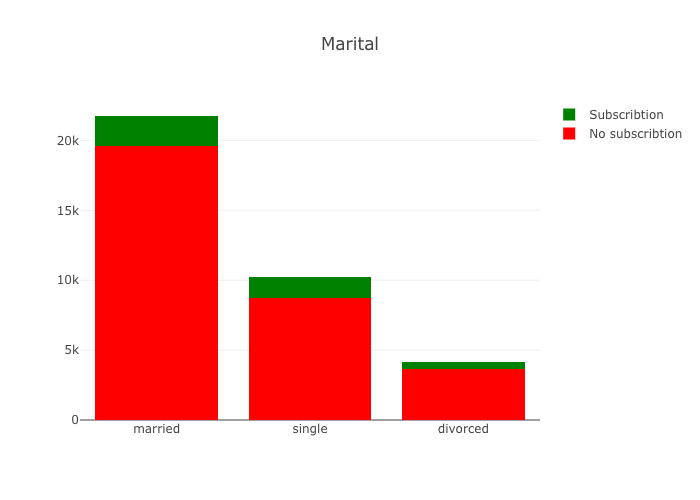

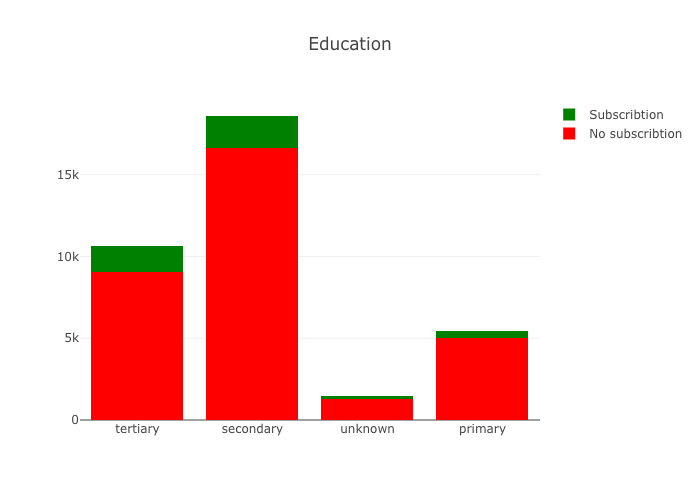

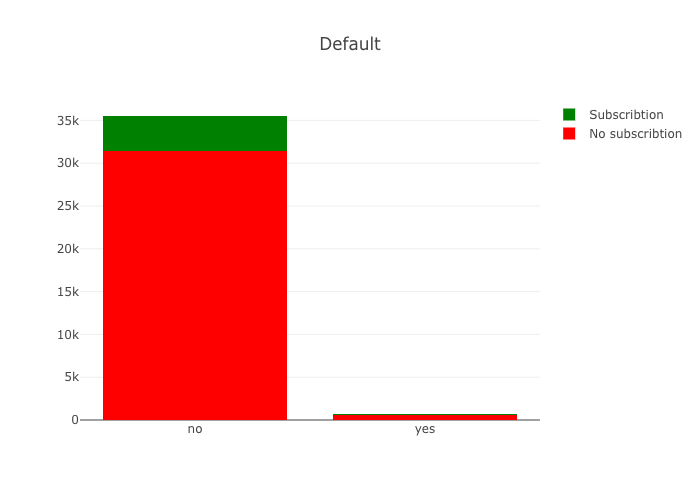

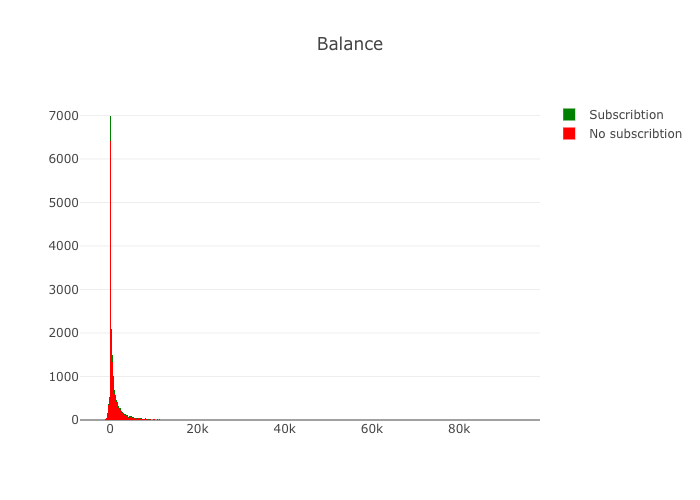

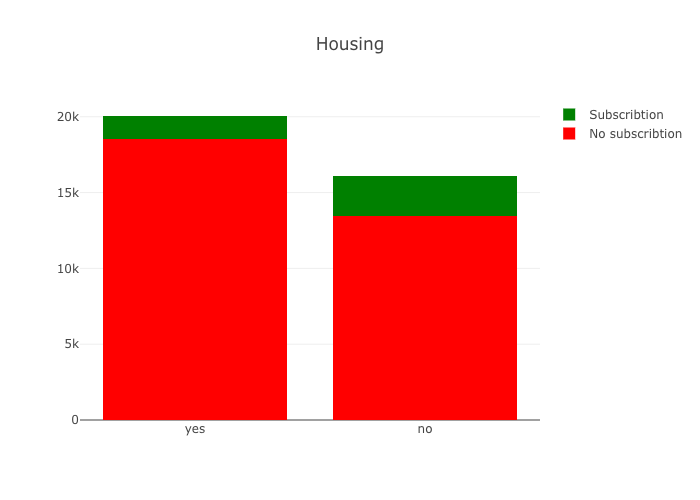

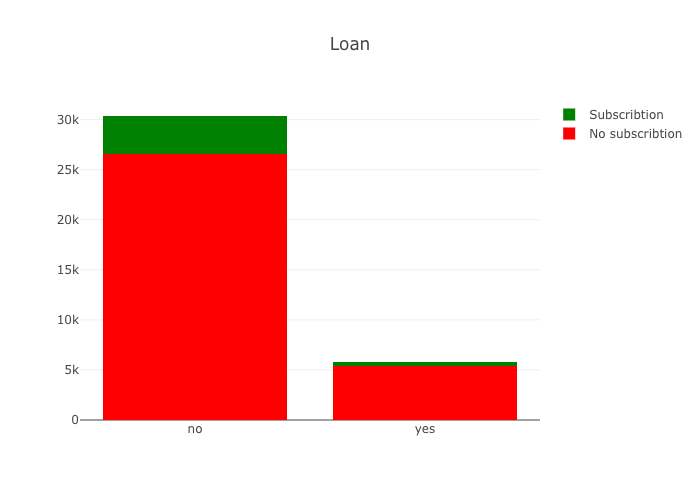

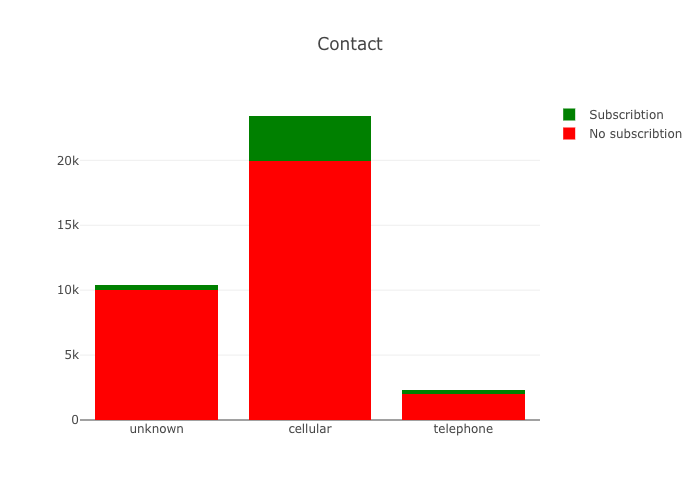

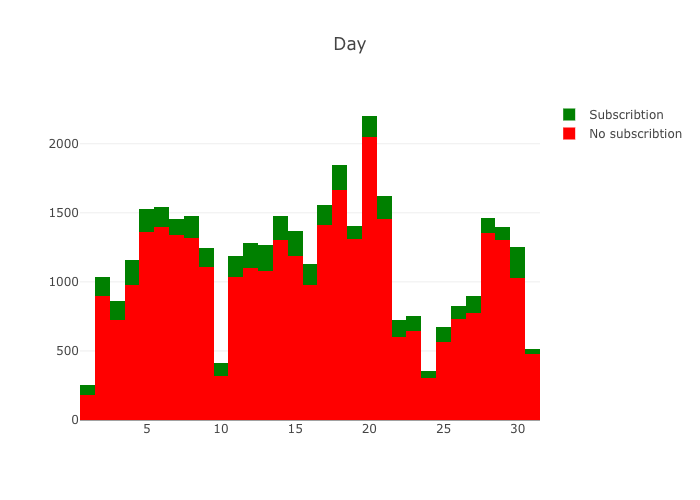

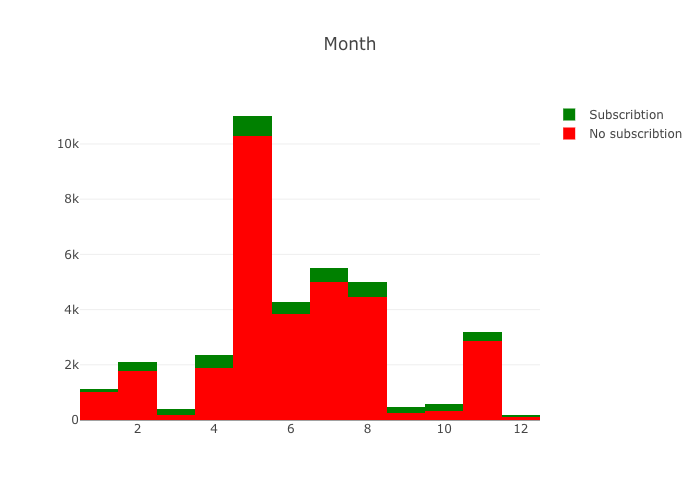

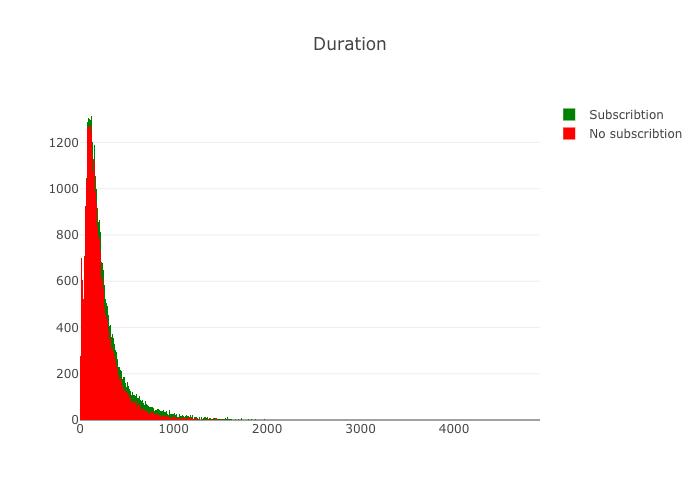

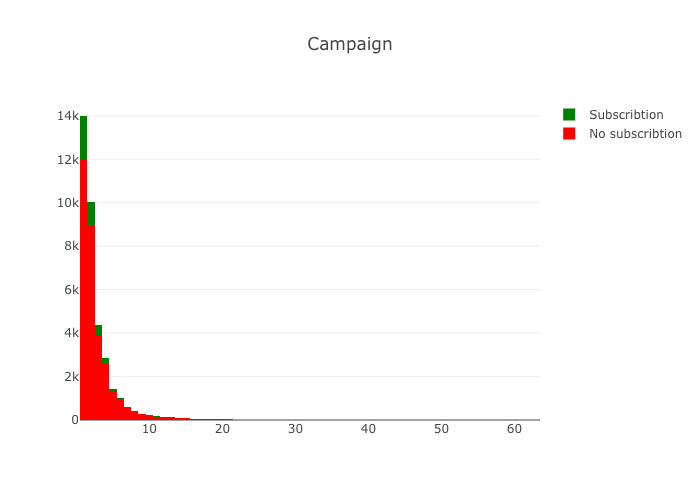

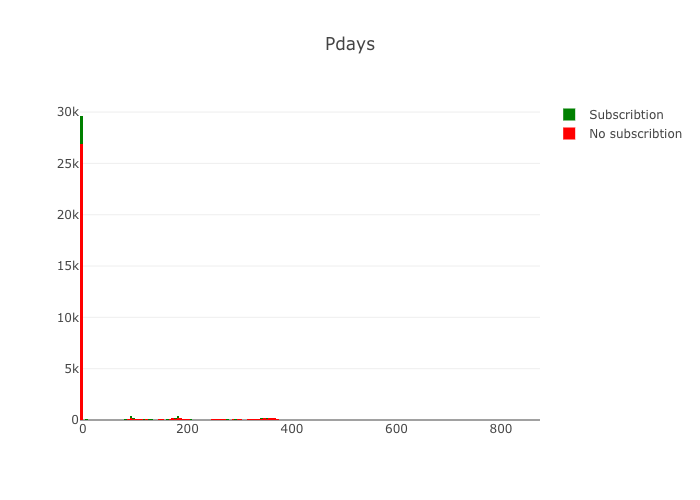

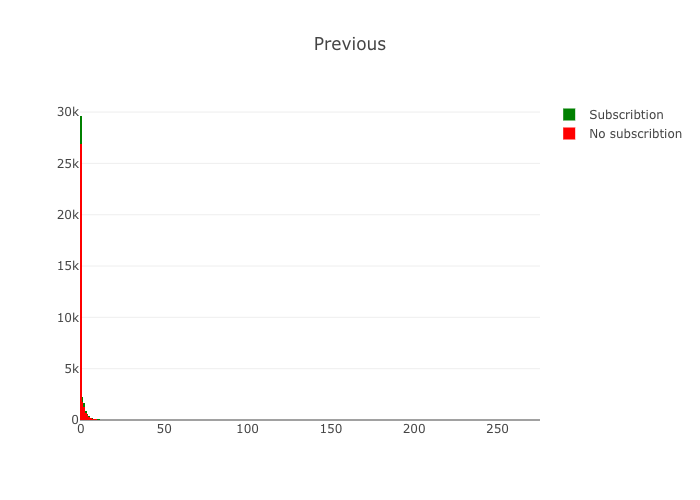

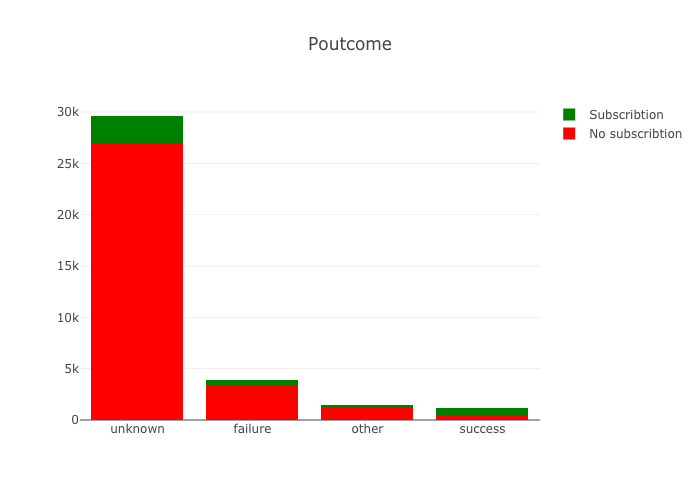

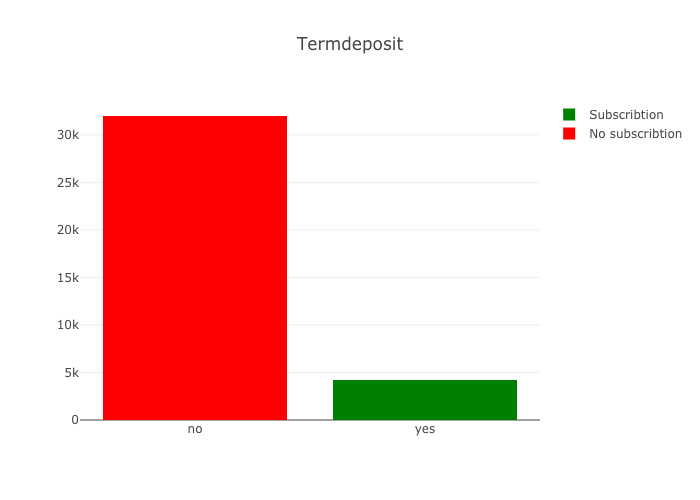

In [4]:
attributes = [atr for atr, typ in dict(df.dtypes).items()]
for atr in attributes:
    trace0 = go.Histogram(
        x=df[df['termDeposit']=='no'][atr],
        name='No subscribtion',
        marker=dict(color='red'),
    )
    trace1 = go.Histogram(
        x=df[df['termDeposit']=='yes'][atr],
        name='Subscribtion',
        marker=dict(color='green'),
    )
    data = [trace0, trace1]
    layout = go.Layout(barmode='stack', title=atr.capitalize())
    fig = go.Figure(data=data, layout=layout)
    static_image_bytes = pio.to_image(fig, format='png')
    if exporting == True:
        display(Image(static_image_bytes))
    else:
        display(iplot(fig))

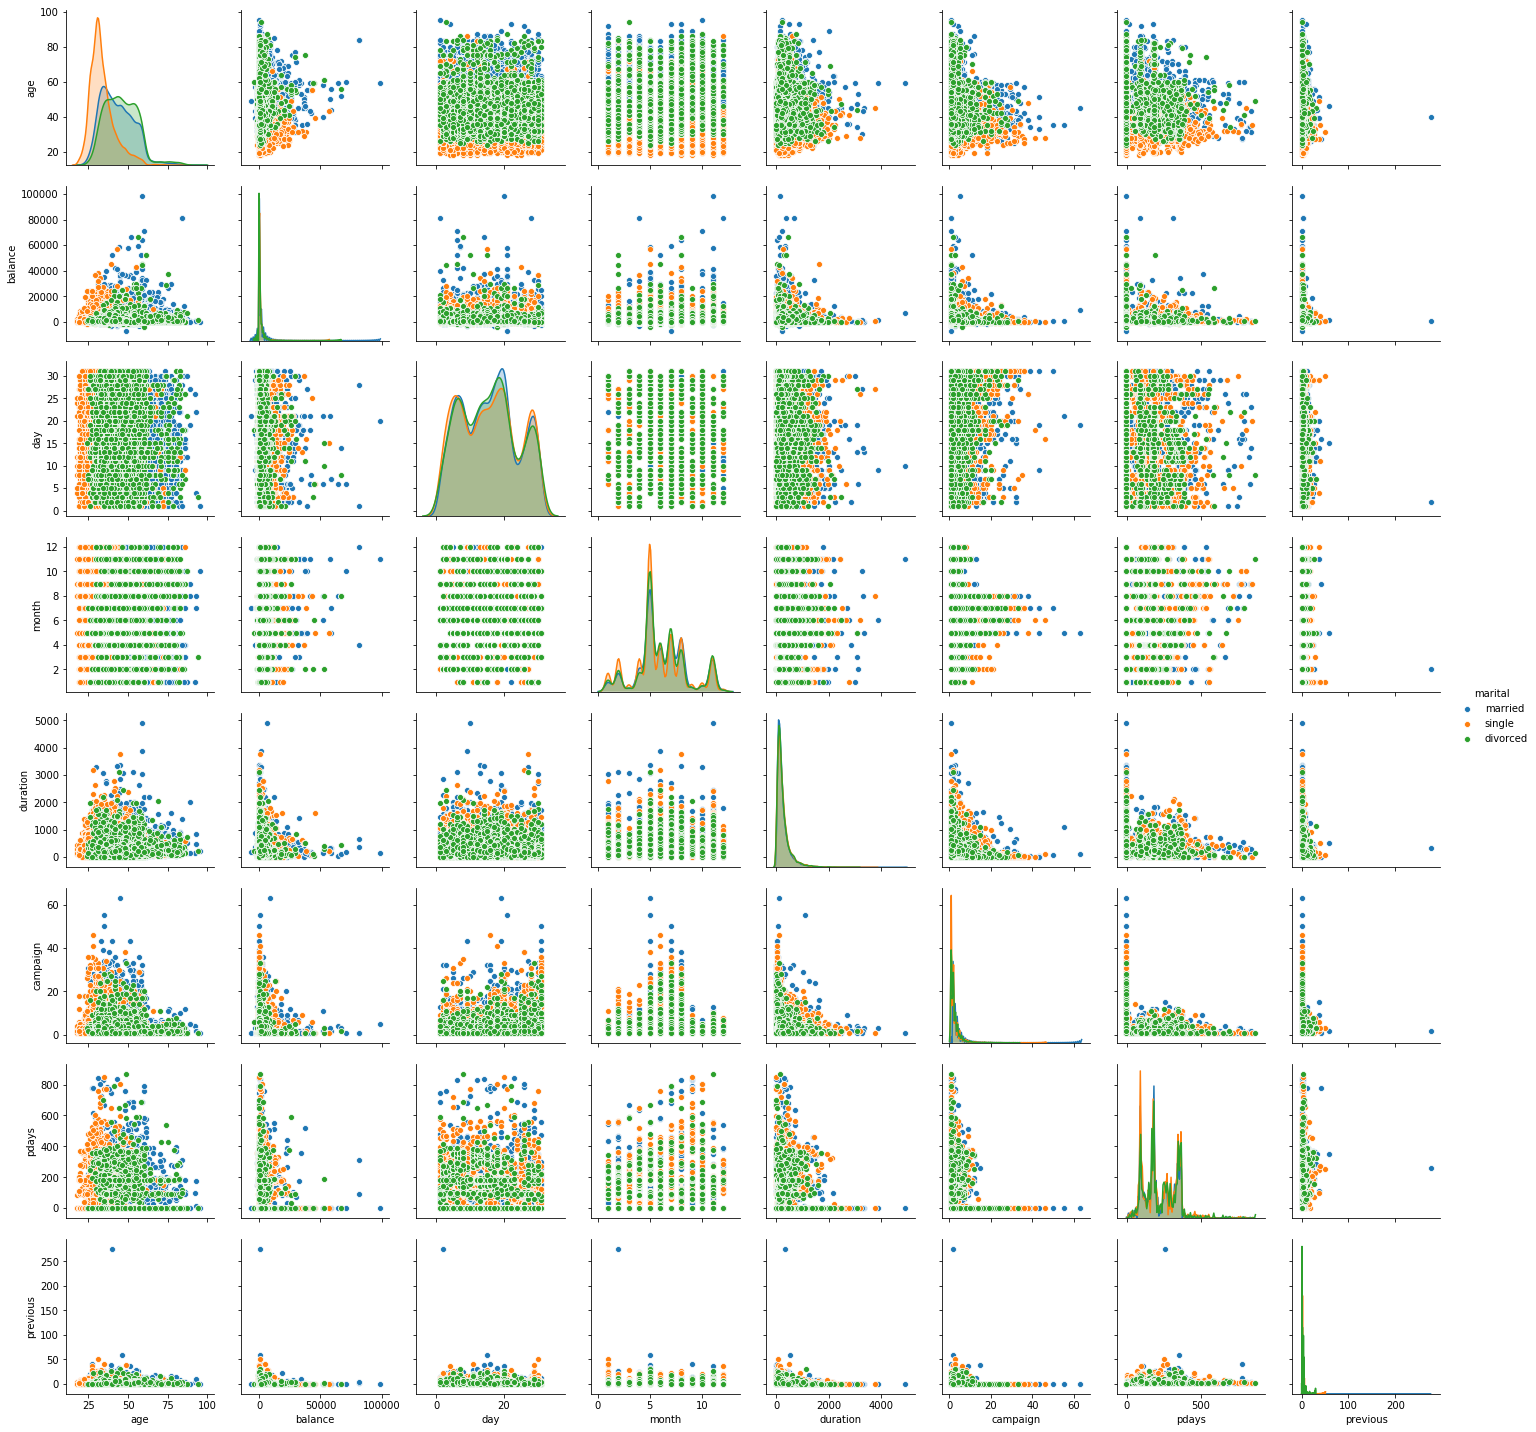

In [5]:
sns.pairplot(df, hue='marital');

The dataset was supplied as an ARFF file. It is compatible with the majority of data mining toolkits.

Initial exploration of the training dataset showed the following features.


* Approximately 88.4% of the data belongs to the 'no' class. This is the accuracy of the default classifier.
* There are 10 _categorical_ and 7 _numerical_ attributes in the dataset.
* The majority of _yes_'s are at the end of the data. We should shuffle rows.
* There are no missing values.
* There are 17 input attributes and 36k labelled examples. This suggests that it may be beneficial to reduce the number of attributes to avoid overfitting.
* Viewing the histograms for each variable showed that there were no variables that were strongly predictive of the class. 
* Some attributes have quite imbalanced distributions of its values. Our algorithms may benefit from the bounding of some attribute values. 
* Job attribute may need to be devided into groups. Usually models benefit from that.
* Some attributes may be irrelevant/redundant. The further exploration is needed to determine the significance of the attributes.    
* Existing credits and duration: numeric attributes with a very strongly skewed distribution. These strongly non-Gaussian distributions may affect the naive Bayes model (which fits a Gaussian distribution to numeric variables) so results for this model may be improved by processing the variables (for example, by discretisation).
* Two-dimensional scatter plots don’t show strong class separation; this suggests that several attributes will be needed to separate the two classes.



We would want to cut the tails of the following attributes

* Age, cut right tail at 82 or even 60
* Restrict balance to values from -50 to 2k
* Duration, from 0 to 2k
* Campaign, form 0 to 20
* _It is not quite clear how to deal with Pdays and Previous attributes_

Alternatively we may try to group the values.

# Data Preparation

Now month is not a categorical variable.

In [6]:
df['termDeposit'] = df['termDeposit'].apply(lambda x: 0 if x == 'no' else 1)
df_features = df.drop(columns='termDeposit')

In [7]:
df_categorical = df_features.select_dtypes([object])
df_numerical = df_features.select_dtypes([int, float])

In [8]:
# create dummy variables for df_categorical
from sklearn.preprocessing import OneHotEncoder

df_one_hot = pd.concat([df_numerical, df['termDeposit']], axis=1)
catergorical_attributes = dict()
for atr in df_categorical.columns:
    df_dummies = pd.get_dummies(df[atr], prefix = atr)
    catergorical_attributes[atr] = [col.split('_')[1] for col in df_dummies.columns]
    df_one_hot = pd.concat([df_one_hot, df_dummies], axis=1) # the dataset ready to appy decision tree algorithm

display(df_one_hot.head())

,age,balance,day,month,duration,campaign,pdays,previous,termDeposit,job_admin.,...,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58.0,2143.0,5.0,5,261.0,1.0,-1.0,0.0,0,0,...,1,1,0,0,0,1,0,0,0,1
1,44.0,29.0,5.0,5,151.0,1.0,-1.0,0.0,0,0,...,1,1,0,0,0,1,0,0,0,1
2,33.0,2.0,5.0,5,76.0,1.0,-1.0,0.0,0,0,...,1,0,1,0,0,1,0,0,0,1
3,47.0,1506.0,5.0,5,92.0,1.0,-1.0,0.0,0,0,...,1,1,0,0,0,1,0,0,0,1
4,35.0,231.0,5.0,5,139.0,1.0,-1.0,0.0,0,0,...,1,1,0,0,0,1,0,0,0,1


In [9]:
attribute_order_one_hot = []
for i in range(len(df.columns)):
    if df.columns[i] in catergorical_attributes.keys():
        print(i, df.columns[i])
        categories = [df.columns[i] + '_' + cat for cat in catergorical_attributes[df.columns[i]]]
        attribute_order_one_hot.extend(categories)
    else:
        attribute_order_one_hot.append(df.columns[i])
        
df_one_hot_ordered = df_one_hot[attribute_order_one_hot]
df_one_hot_ordered.head()

1 job
2 marital
3 education
4 default
6 housing
7 loan
8 contact
15 poutcome


,age,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,...,month,duration,campaign,pdays,previous,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,termDeposit
0,58.0,0,0,0,0,1,0,0,0,0,...,5,261.0,1.0,-1.0,0.0,0,0,0,1,0
1,44.0,0,0,0,0,0,0,0,0,0,...,5,151.0,1.0,-1.0,0.0,0,0,0,1,0
2,33.0,0,0,1,0,0,0,0,0,0,...,5,76.0,1.0,-1.0,0.0,0,0,0,1,0
3,47.0,0,1,0,0,0,0,0,0,0,...,5,92.0,1.0,-1.0,0.0,0,0,0,1,0
4,35.0,0,0,0,0,1,0,0,0,0,...,5,139.0,1.0,-1.0,0.0,0,0,0,1,0


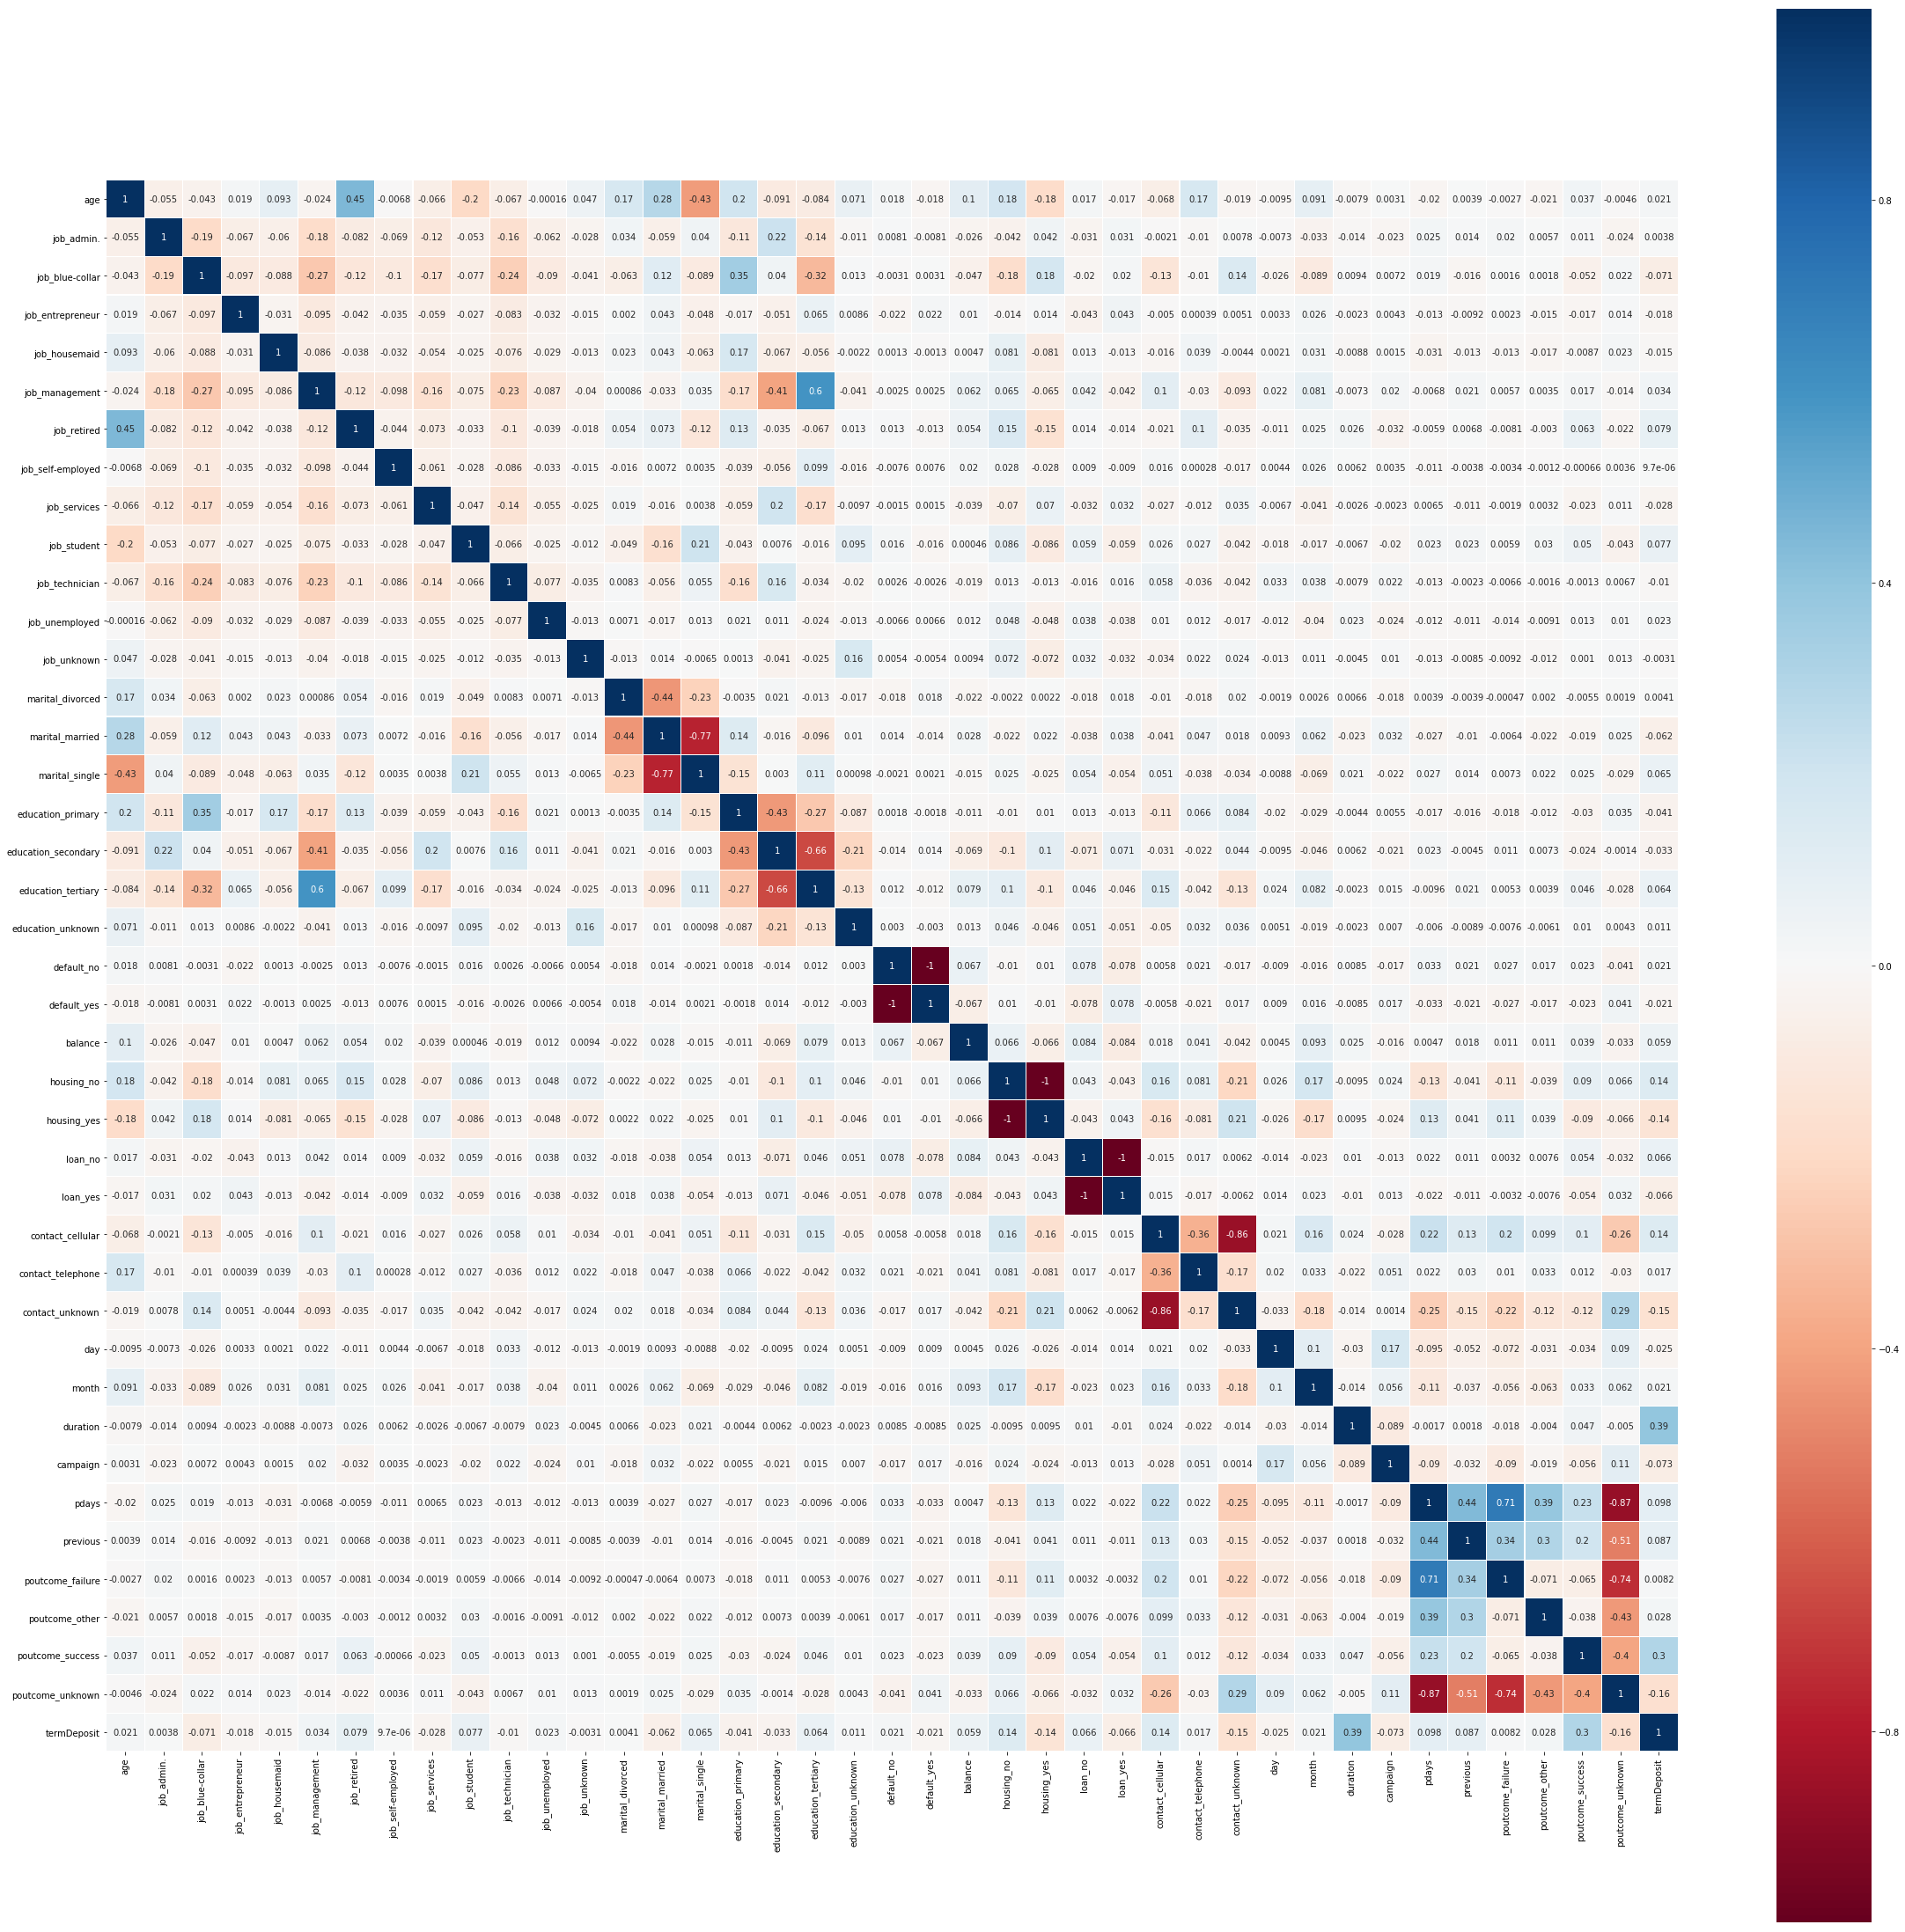

In [10]:
plt.figure(figsize=(40,40))
sns.heatmap(df_one_hot_ordered.astype(float).corr(),linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

# Classification Models

Let's apply classification models to our dataset as it is.

In [11]:
scores = pd.DataFrame()

# Data Preprocessing

Separate numeric attributes and object attributes.

## Standartisation and PCA

In [12]:
df_shuffle = shuffle(df_one_hot_ordered)
X_train, X_test, y_train, y_test = train_test_split(df_shuffle.drop('termDeposit', axis=1), df_shuffle['termDeposit'], test_size=0.33, random_state=45)
display(df_shuffle.head(), X_train.shape)

,age,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,...,month,duration,campaign,pdays,previous,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,termDeposit
16641,33.0,0,0,0,0,0,0,0,0,0,...,8,182.0,8.0,-1.0,0.0,0,0,0,1,0
32741,25.0,0,0,0,0,1,0,0,0,0,...,8,222.0,2.0,104.0,2.0,1,0,0,0,0
13346,51.0,0,1,0,0,0,0,0,0,0,...,7,240.0,5.0,-1.0,0.0,0,0,0,1,0
8525,53.0,0,0,0,0,0,1,0,0,0,...,6,254.0,1.0,-1.0,0.0,0,0,0,1,0
29240,32.0,0,0,0,0,0,0,0,0,0,...,5,85.0,4.0,350.0,1.0,1,0,0,0,0


(24233, 40)

# Default Classifier

In [13]:
dummycls = DummyClassifier('most_frequent')
dummycls.fit(X_train, y_train)
scores_default = cross_val_score(dummycls, df_shuffle.drop('termDeposit', axis=1), df_shuffle['termDeposit'], cv=10)
scores['Default'] = pd.Series(scores_default)

# Decision Tree

In [14]:
tree = DecisionTreeClassifier(min_impurity_decrease=0.001)
tree.fit(X_train, y_train);

In [15]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, tree.predict(X_test)))
print(confusion_matrix(y_test, tree.predict(X_test)))

DecisionTrees's Accuracy:  0.8958612600536193
[[10270   237]
 [ 1006   423]]


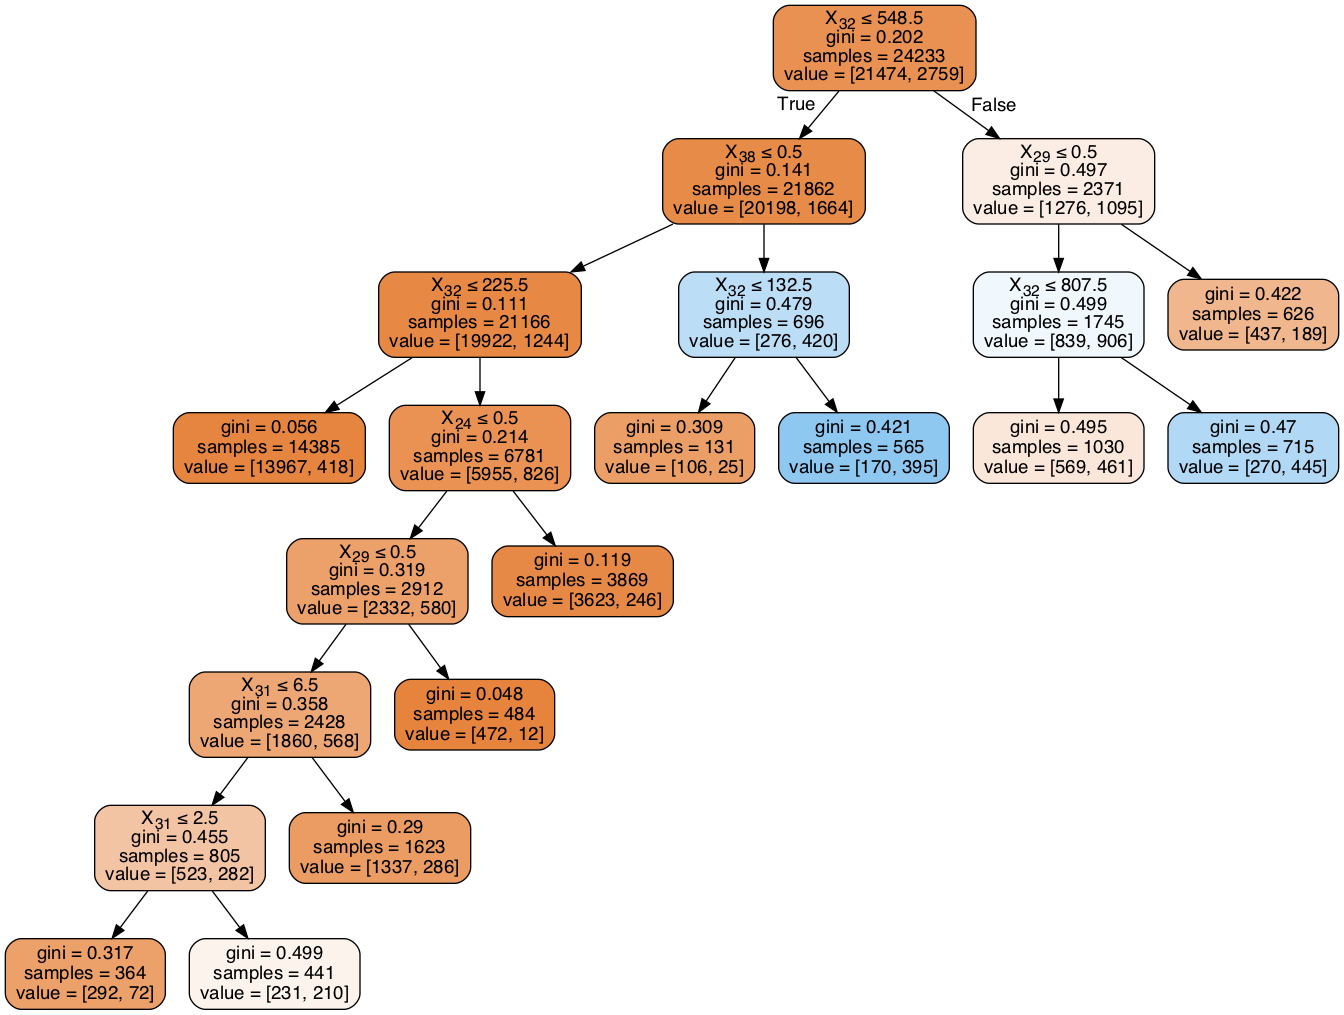

In [16]:
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [17]:
scores_tree = cross_val_score(tree, df_shuffle.drop('termDeposit', axis=1), df_shuffle['termDeposit'], cv=10)
scores['Decision Tree'] = pd.Series(scores_tree)
pd.DataFrame(scores_tree, columns=['Decision Tree']).describe()

,Decision Tree
count,10.000000
mean,0.897619
std,0.004260
min,0.888029
25%,0.896239
50%,0.897415
75%,0.901092
max,0.902682


This classifier is good enough. We can assert that it is better than the default classifier.

Because ... Statistical Hypothesis checking!

# Naive Bayes

In [18]:
gnb_all_data = GaussianNB().fit(X_train, y_train)
scores_nb_all = cross_val_score(gnb_all_data, df_shuffle.drop('termDeposit', axis=1), df_shuffle['termDeposit'], cv=10)
pd.DataFrame(scores_nb_all, columns=['Gaussian NB']).describe()

,Gaussian NB
count,10.000000
mean,0.824075
std,0.009972
min,0.804757
25%,0.817943
50%,0.825432
75%,0.831628
max,0.836605


It performs even worse than a default classifier. It may be due to the unevenly distributed data, long tails, and hight attribute count. Most likely it is because the distributions are far from being normal.

In [19]:
number_attributes = [atr for atr, typ in dict(df_features.dtypes).items() if str(typ) in ['float64','int64']]
object_attributes_one_hot = list(set(attribute_order_one_hot) - set(['termDeposit']) - set(number_attributes))


gnb_number_atr = GaussianNB().fit(X_train[number_attributes], y_train)
scores_nb_number_atr = cross_val_score(gnb_number_atr, df_shuffle[number_attributes], df_shuffle['termDeposit'], cv=10)
scores['NB numerical atr'] = pd.Series(scores_nb_number_atr)
pd.DataFrame(scores_nb_number_atr, columns=['Gaussian NB']).describe()

,Gaussian NB
count,10.000000
mean,0.873261
std,0.005603
min,0.861173
25%,0.870930
50%,0.874620
75%,0.877272
max,0.880011


It performs much better it being fitted by numerical attributes.

In [20]:
gnb_category_atr = GaussianNB().fit(X_train[object_attributes_one_hot], y_train)
scores_nb_cat_atr = cross_val_score(gnb_category_atr, df_shuffle[object_attributes_one_hot], df_shuffle['termDeposit'], cv=10)
pd.DataFrame(scores_nb_cat_atr, columns=['Gaussian NB']).describe()

,Gaussian NB
count,10.000000
mean,0.809146
std,0.007615
min,0.796184
25%,0.806041
50%,0.806884
75%,0.815040
max,0.820570


# KNN

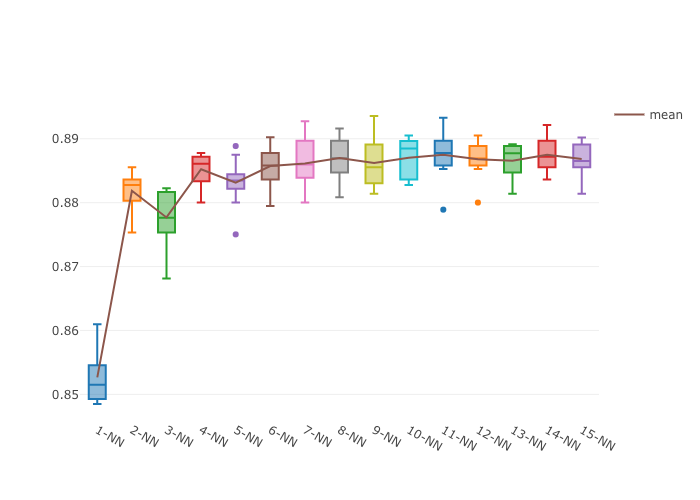

In [21]:
knn_results = pd.DataFrame()

for n in range(1,16):
    knn_all_atr = KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train)
    scores_knn_all = cross_val_score(knn_all_atr, df_shuffle.drop('termDeposit', axis=1), df_shuffle['termDeposit'], cv=10)
    knn_results['{}-NN'.format(n)] = pd.Series(scores_knn_all)

data = []
for col in knn_results.columns:
    data.append(go.Box(y=knn_results[col], name=col, showlegend=False ) )

data.append(go.Scatter(x=knn_results.columns, y = knn_results.mean(), mode='lines', name='mean'))

fig = go.Figure(data=data)
if exporting == True:
    static_image_bytes = pio.to_image(fig, format='png')
    display(Image(static_image_bytes))
else:
    display(iplot(fig))

In [22]:
for n in [8, 13, 14, 15]:
    scores['{} Nearest N'.format(n)] = knn_results['{}-NN'.format(n)]

# Logistic Regression

In [23]:
logreg = LogisticRegression(random_state=0, solver='sag', max_iter=10000).fit(X_train, y_train)
scores_logreg = cross_val_score(logreg, df_shuffle.drop('termDeposit',axis=1), df_shuffle['termDeposit'], cv=10)
scores['Logistic R'] = pd.Series(scores_logreg)

# Random Forests

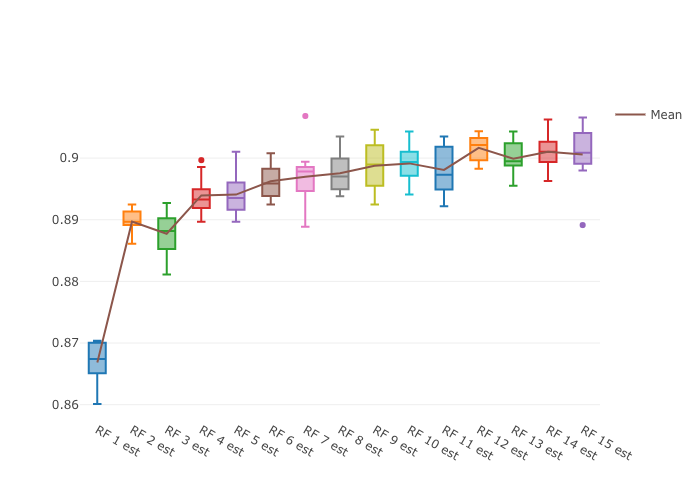

In [24]:
scores_randforest = pd.DataFrame()
for n in range(1, 16):
    randforest = RandomForestClassifier(n_estimators=n).fit(X_train, y_train)
    scores_randforest_cvs = cross_val_score(randforest, df_shuffle.drop('termDeposit',axis=1), df_shuffle['termDeposit'], cv=10)
    scores_randforest['RF {} est'.format(n)] = pd.Series(scores_randforest_cvs)
    if n in [10, 15]:
        scores['RandomF {} trees'.format(n)] = pd.Series(scores_randforest_cvs)

data = []
for col in scores_randforest.columns:
    data.append(go.Box(y=scores_randforest[col], name=col, showlegend=False))

data.append(go.Scatter(x=scores_randforest.columns, y = scores_randforest.mean(), mode='lines', name='Mean'))

fig = go.Figure(data=data)
if exporting == True:
    static_image_bytes = pio.to_image(fig, format='png')
    display(Image(static_image_bytes))
else:
    display(iplot(fig))

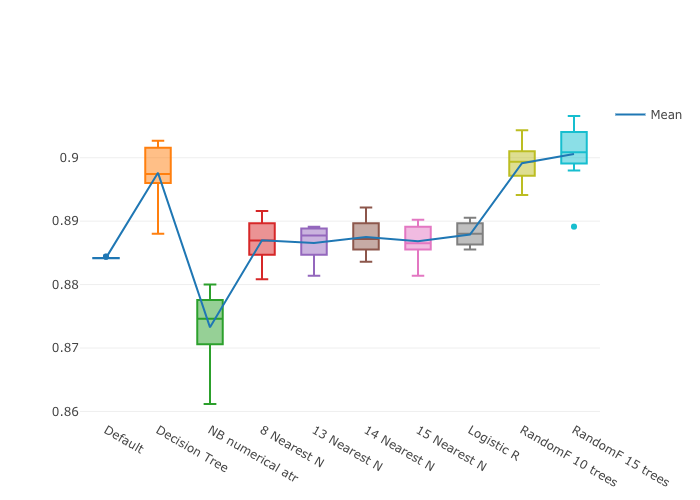

In [25]:
data = []
for col in scores.columns:
    data.append(go.Box(y=scores[col], name=col, showlegend=False))

data.append(go.Scatter(x=scores.columns, y = scores.mean(), mode='lines', name='Mean'))

fig = go.Figure(data=data)
if exporting == True:
    static_image_bytes = pio.to_image(fig, format='png')
    display(Image(static_image_bytes))
else:
    display(iplot(fig))

The more trees in the forest, the better.

# Conclusions

For production I am tempted to recommend Decision Tree classifier.